## Creating the dataset and training the model

In [1]:
# import the packages
import os
import pandas as pd
import numpy as np

import torch 
import torchaudio
from torch.utils.data import DataLoader, random_split

import IPython.display as ipd
import matplotlib.pyplot as plt

from utils import *
from model import BirdAudioClassifierModel, ModelTrainer

### Checking if cuda is available

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A500 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Creating a Custom Dataset

In [3]:
#load metadata df 
current_dir = os.getcwd() 
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata = pd.read_csv(file_path)
#test
df_metadata = df_metadata.head(100)
display(df_metadata)

,file_id,original_file_id,english_cname,path,class_id
0,1,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
1,2,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
2,3,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
3,4,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
4,5,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
...,...,...,...,...,...
95,96,102060,Common Linnet,C:\Users\bensa\Documents\Aberdeen University\U...,7
96,97,102060,Common Linnet,C:\Users\bensa\Documents\Aberdeen University\U...,7
97,98,102060,Common Linnet,C:\Users\bensa\Documents\Aberdeen University\U...,7
98,99,102060,Common Linnet,C:\Users\bensa\Documents\Aberdeen University\U...,7


In [4]:
#create a dataset
birdsong_dataset = AudioDataSet(df_metadata=df_metadata)

#create training, validation, and test set. (60, 20, 20) split
train_size = int(0.6 * len(birdsong_dataset))
val_size = int(0.2 * len(birdsong_dataset))
test_size = len(birdsong_dataset) - train_size - val_size

#use random_split to perform the split 
train_dataset, val_dataset, test_dataset = random_split(birdsong_dataset, [train_size, val_size, test_size])

#print the lengths of each set
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60
Validation set size: 20
Test set size: 20


In [5]:
#create the training, validation and test data loaders  (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Shape of spectrograms: torch.Size([16, 1, 401, 552]), Class ids: tensor([7, 2, 2, 3, 2, 5, 7, 6, 4, 2, 5, 5, 5, 6, 1, 2])


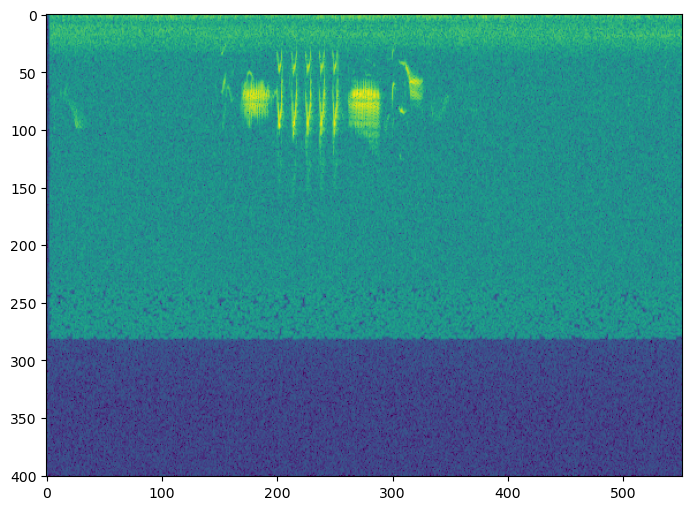

In [6]:
#test data loaders 
spectrograms, class_id = next(iter(train_dataloader)) 
print(f"Shape of spectrograms: {spectrograms.size()}, Class ids: {class_id}")
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0,0,:,:].numpy())

### Creating the model
Each batch has a shape of (batch_size, num_channels, frequency_bands, time_steps). This means that each input (each spectrogram) is of size frequency_bands x time_steps which in our case is 401 x 552 = 221352.

The audio has not been transformed to spectrogram images so now we can use standard image classification techniques. This means we are going to use a CNN model to classify the spectrogram images. (image classification paper/source) 


In [7]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

In [8]:
# class BirdAudioClassifier(nn.Module): 
#     def __init__(self, num_classes=88): 
#         super().__init__() 
#         #define the different layers 
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #number of input channels, number of output channels (number of filters that will be applied), 
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
#         #define max pooling 
#         self.max_pool = nn.MaxPool2d(2, 2)
#         #layer to flatten the output 
#         self.flatten = nn.Flatten() 
#         #fully connected layer for classification 
#         self.fc1 = nn.Linear(411648, 512)
#         self.fc2 = nn.Linear(512, num_classes)
    
#     #implement the forward propagation through the network
#     def forward(self, x): 
#         #first convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv1(x)))
#         #second convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv2(x)))
#         #third convolutional layer + relu + max pool layer
#         x = self.max_pool(F.relu(self.conv3(x)))
#         #flatten the output from the convolutional layer 
#         x = self.flatten(x) 
#         #first fully connected layer 
#         x = F.relu(self.fc1(x)) 
#         #second fully connected layer 
#         x = self.fc2(x) 
#         #softmax activation function to convert the logits to log probabilities
#         x = F.log_softmax(x, dim=1)
#         return x

In [9]:
# #testing 
# num_bird_classes = 88
# test_model = BirdAudioClassifier(num_classes=num_bird_classes).to(device)
# print(test_model)

# #save the model (its parameters) so that it can be loaded again
# torch.save(test_model.state_dict(), 'Models\model_test.pth')

In [10]:
# #testing the model with input (for prediction) 
# spectrograms_test = spectrograms.to(device) 
# # Set the model to evaluation mode
# test_model.eval()
# # Forward pass to get predictions
# with torch.no_grad():
#     predictions = test_model(spectrograms_test)

# # 'predictions' now contains the log probabilities for each class
# # You can use torch.exp to convert them to probabilities if needed
# probabilities = torch.exp(predictions)
# # Print or use the results as needed
# print(probabilities)

# # Find the maximum probability and its corresponding index along the second dimension (num_classes)
# max_probabilities, predicted_classes = torch.max(probabilities, dim=1)

# # 'max_probabilities' contains the highest probability for each output tensor in the batch
# # 'predicted_classes' contains the index of the class with the highest probability for each output tensor

# # Print or use the results as needed
# print(max_probabilities)
# print(predicted_classes)

### Training the model

In [11]:
'''
num_bird_classes = 88
model = BirdAudioClassifierModel(num_classes=num_bird_classes).to(device) 

#loss function to find the best parameters 
loss_func = torch.nn.CrossEntropyLoss() 

#define the learning rate 
learning_rate = 0.0001
#define the optimizer (using adam optimizer) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#function to train the model 
def train(dataloader, model, loss, optimizer): 
    #set the model in training mode 
    model.train() 

    size = len(dataloader.dataset)

    #keep track of the total loss 
    total_loss = 0

    #loop over each batch
    for batch, (X, Y) in enumerate(dataloader): 
        #move all tensors to the device 
        X = X.to(device)
        Y = Y.to(device)

        #zero the gradient
        optimizer.zero_grad() 
        #get the model predictions 
        predictions = model(X)
        #compute the loss using the prediction and the label
        loss = loss_func(predictions, Y)

        total_loss += loss
        
        #perform backpropagation 
        loss.backward() 
        optimizer.step() 

        #print progress
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

    #calcualte the average loss
    avg_loss = total_loss / size
    return avg_loss

#create test function for test and validation set
def test(dataloader, model): 
    #set the model in evaluation mode 
    model.eval() 
    #initialize the total test loss and the number of correct predictions 
    total_test_loss, correct_pred = 0, 0 

    #loop through the batch 
    with torch.no_grad(): 
        for batch, (X, Y) in enumerate(dataloader): 
            #move all tensors to the device 
            X = X.to(device)
            Y = Y.to(device)
            #predit classes 
            predictions = model(X) 

            #compute loss 
            total_test_loss += loss_func(predictions, Y).item() 
            correct_pred += (predictions.argmax(1)==Y).type(torch.float).sum().item()

    #comput the average loss and accuracy 
    avg_test_loss = total_test_loss / len(dataloader.dataset) 
    avg_correct_pred = correct_pred / len(dataloader.dataset) 

    print(f'\nTest Error:\nacc: {(100*avg_correct_pred):>0.1f}%, avg loss: {avg_test_loss:>8f}\n')
    return avg_test_loss
'''

"\nnum_bird_classes = 88\nmodel = BirdAudioClassifierModel(num_classes=num_bird_classes).to(device) \n\n#loss function to find the best parameters \nloss_func = torch.nn.CrossEntropyLoss() \n\n#define the learning rate \nlearning_rate = 0.0001\n#define the optimizer (using adam optimizer) \noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n#function to train the model \ndef train(dataloader, model, loss, optimizer): \n    #set the model in training mode \n    model.train() \n\n    size = len(dataloader.dataset)\n\n    #keep track of the total loss \n    total_loss = 0\n\n    #loop over each batch\n    for batch, (X, Y) in enumerate(dataloader): \n        #move all tensors to the device \n        X = X.to(device)\n        Y = Y.to(device)\n\n        #zero the gradient\n        optimizer.zero_grad() \n        #get the model predictions \n        predictions = model(X)\n        #compute the loss using the prediction and the label\n        loss = loss_func(predictions, 

In [12]:
#testing training class 
model = BirdAudioClassifierModel(num_classes=88)
#create trainer 
model_trainer = ModelTrainer(model=model, learning_rate=0.0001)

train_losses, test_losses = model_trainer.train(num_epochs=1, train_dataloader=train_dataloader, 
                                                test_dataloader=test_dataloader)


print(train_losses) 
print(test_losses)

#saving the trained model
# model_trainer.save_model('Models\model2.pth')



Saved model at: Models\model_test.pth
Loaded model from: Models\model_test.pth


In [12]:
# #train the model 
# num_epochs = 15

# train_losses = []
# test_losses = []
# epochs = [i for i in range(1, num_epochs +1)]

# for t in range(num_epochs):
#     print(f'Epoch {t+1}\n-------------------------------')
#     #train the model 
#     train_loss = train(train_dataloader, model, loss_func, optimizer)
#     train_losses.append(train_loss)
#     #test the model 
#     test_loss = test(test_dataloader, model)
#     test_losses.append(test_loss)
# print('Done!')

# #save the model 
# torch.save(model.state_dict(), 'Models\model2.pth')

Epoch 1
-------------------------------
loss: 4.619719  [    0/ 2128]
loss: 2.442325  [ 1600/ 2128]

Test Error:
acc: 33.8%, avg loss: 0.192301

Epoch 2
-------------------------------
loss: 1.646204  [    0/ 2128]
loss: 0.801921  [ 1600/ 2128]

Test Error:
acc: 57.2%, avg loss: 0.111156

Epoch 3
-------------------------------
loss: 0.556864  [    0/ 2128]
loss: 0.226950  [ 1600/ 2128]

Test Error:
acc: 66.8%, avg loss: 0.097730

Epoch 4
-------------------------------
loss: 0.076049  [    0/ 2128]
loss: 0.300554  [ 1600/ 2128]

Test Error:
acc: 68.6%, avg loss: 0.088053

Epoch 5
-------------------------------
loss: 0.221388  [    0/ 2128]
loss: 0.044149  [ 1600/ 2128]

Test Error:
acc: 72.0%, avg loss: 0.088862

Epoch 6
-------------------------------
loss: 0.006620  [    0/ 2128]
loss: 0.008815  [ 1600/ 2128]

Test Error:
acc: 72.3%, avg loss: 0.080625

Epoch 7
-------------------------------
loss: 0.005029  [    0/ 2128]
loss: 0.002715  [ 1600/ 2128]

Test Error:
acc: 75.1%, avg l

### Model evaluation 
- plot losses over time
- evaluated the classifier on the validation set

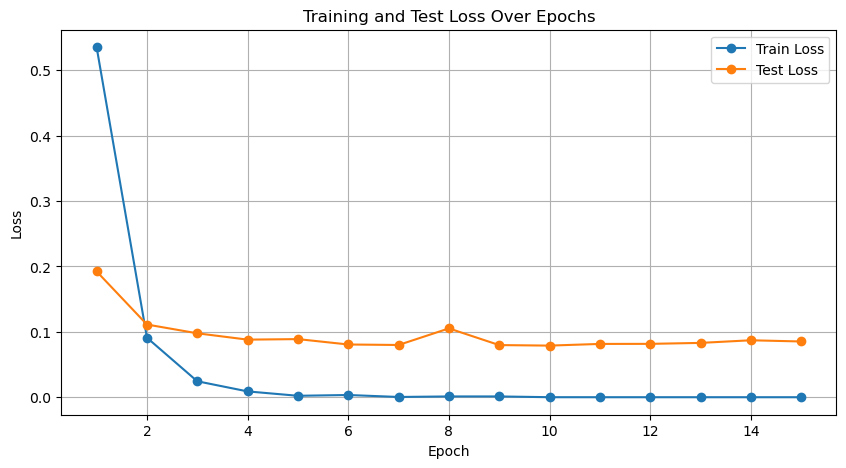

In [5]:
# print(f"num_epochs: {epochs}")
# print(f"train_losses: {train_losses}")
# print(f"test_losses: {test_losses}")


train_losses = [0.5351, 0.0910, 0.0244, 0.0089, 0.0022, 0.0034, 0.0004, 0.0012, 0.0012, 
                5.5362e-05, 2.5600e-05, 1.8612e-05, 1.4597e-05, 1.1913e-05, 9.8767e-06]
test_losses = [0.19230097624487683, 0.1111558004270626, 0.09772972404202328, 0.0880531294771723, 
               0.08886204781495402, 0.08062453062893134, 0.07987135671781252, 0.10522972007508687, 
               0.07972377771315192, 0.07892548589431451, 0.08149178380620799, 0.08158932299826048, 
               0.08307232887977957, 0.08706862190227468, 0.08522877969245954]
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#plot the loss 
import matplotlib.pyplot as plt

# Assuming you have the train_losses and test_losses lists from your training loop

# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')

plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Save the plot as an image file
plt.savefig('Models\loss_plot_model1.png')
plt.show()

In [4]:
#testing the model on the validation set 
spectrograms_val, class_id_val = next(iter(val_dataloader)) 
spectrograms_val = spectrograms_val.to(device) 

# Set the model to evaluation mode
model.eval()
# Forward pass to get predictions
with torch.no_grad():
    predictions = model(spectrograms_val)

# 'predictions' now contains the log probabilities for each class
# You can use torch.exp to convert them to probabilities if needed
probabilities = torch.exp(predictions)
# Print or use the results as needed
print(probabilities)

# Find the maximum probability and its corresponding index along the second dimension (num_classes)
max_probabilities, predicted_classes = torch.max(probabilities, dim=1)

# 'max_probabilities' contains the highest probability for each output tensor in the batch
# 'predicted_classes' contains the index of the class with the highest probability for each output tensor

# Print or use the results as needed
print(max_probabilities)
print(predicted_classes)

NameError: name 'val_dataloader' is not defined